Get Externals, Note use of commentjson

In [1]:
import os,sys,string,time,commentjson,datetime
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

Utility function: object = cummulate(object,lifetime)

In [2]:
# sum backwards over lifetime of record
def cumulate(a,lifetime=100):
  if lifetime < 1:
    return a*lifetime
  b = np.zeros(len(a))
  for i in range(0,len(a)):
    begin = max(0,i-lifetime+1)
    for j in range(begin,i+1):
      b[i] += a[j]
  return b
  

Utility function: string = dump(datatype,det,object,Units)

In [3]:
from NumberUtils import dump


Utility function: DrawDet(Value,Years,Data,Types,Units,detcolors,detlines)

In [4]:
from NumberUtils import DrawDet  


Utility function: DrawType(Value,Years,Data,Types,Units,typecolors,typelines)

In [5]:
# draw by data type (transpose of the detectors)
from NumberUtils import DrawType

Main initialization

Read in the config file "Parameters2040.json"

In [6]:
# get parameters into config

configfile = "Parameters_2040-postLBNC.json"
#configfile = "Parameters_2040.json"
if os.path.exists(configfile):
  with open(configfile,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfile)
  sys.exit(0)

Print the json file 

In [7]:
json_formatted_str = commentjson.dumps(config, indent=2)

#print(json_formatted_str)

    Set up parameters from input file 

In [8]:
# set up shortcuts for parameters

MaxYears = config["MaxYears"]
MinYears = config["MinYears"]
Years = np.array(config["Years"][0:MaxYears])
size = len(Years)

Units = config["Units"]

Detectors = config["Detectors"]

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

RecoMemory = config["RecoMemory"]

Splits = config["Splits"]

PerYear = config["PerYear"]
print (TapeLifetimes)
table = open(configfile.replace("json","txt"),'w')

s = "DUNE resource report\nConfiguration: %s\nDate: %s\n \n "%(configfile,datetime.datetime.utcnow())
print(s)
table.write(s)

s = "Fiscal year starts: %s\nTape is accounted for at: %s\nDisk is accounted for on: %s\nCPU is accounted for at: %s\n"%\
(config["FiscalYearStart"],config["Tape Accounting"],config["Disk Accounting"],config["CPU Accounting"])
table.write(s)
print(s)

s = "Reco passes per Year: %s\nSim passes per Year: %s\nAnalysis relative to Sim+Reco: %s\n"%(PerYear["CPU"],PerYear["Sim-CPU"],config["Analysis"]["Scale"])
table.write(s)
print(s)

for type in TapeLifetimes:
    s = "For data type %s\n"%type
    print (s)
    table.write(s)
    s = "%6s Tape lifetime %5.1f in years\n"%(type,TapeLifetimes[type])
    print (s)
    table.write(s)
    s = "%6s Tape Copies %5.1f\n"%(type,TapeCopies[type])
    print (s)
    table.write(s)
    s = "%6s Collaboration Tape fraction %5.2f\n"%(type,Splits["Tape"][type])
    print (s)
    table.write(s)
    s = "%6s Disk lifetime %5.1f in years\n"%(type,DiskLifetimes[type])
    print (s)
    table.write(s)
    s = "%6s Disk Copies %5.1f\n"%(type,DiskCopies[type])
    print (s)
    table.write(s)
    
    s = "%6s Collaboration Disk fraction %5.2f\n"%(type,Splits["Disk"][type])
    print (s)
    table.write(s)

#table.write("Calendar Years")
    
StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]


{'Raw': 100, 'Test': 0.5, 'Reco': 15, 'Sim': 15}
DUNE resource report
Configuration: Parameters_2040-postLBNC.json
Date: 2021-03-23 20:14:49.491887
 
 
Fiscal year starts: April 1
Tape is accounted for at: end of fiscal year
Disk is accounted for on: October 1
CPU is accounted for at: end fiscal year

Reco passes per Year: 1
Sim passes per Year: 1
Analysis relative to Sim+Reco: 1

For data type Raw

   Raw Tape lifetime 100.0 in years

   Raw Tape Copies   2.0

   Raw Collaboration Tape fraction  0.50

   Raw Disk lifetime   0.5 in years

   Raw Disk Copies   1.0

   Raw Collaboration Disk fraction  0.50

For data type Test

  Test Tape lifetime   0.5 in years

  Test Tape Copies   1.0

  Test Collaboration Tape fraction  0.50

  Test Disk lifetime   0.5 in years

  Test Disk Copies   0.5

  Test Collaboration Disk fraction  0.00

For data type Reco

  Reco Tape lifetime  15.0 in years

  Reco Tape Copies   1.0

  Reco Collaboration Tape fraction  0.50

  Reco Disk lifetime   2.0 in ye

Make data structures - Inputs and Data 

Data[type][det] is an dictionary keyed on type and detector

In [9]:
# build the inputs array

Inputs = {}
PatternFraction = config["PatternFraction"]
# get in the input values (Events and amount of commissioning in TB)
 
# these variables are set in the json 

dofirst = ["Events","Test","Sim Events"]

for det in ["SP","DP","ND","FD"]:
  Inputs[det]={}
  for type in dofirst:
    Inputs[det][type] = np.array(config[det][type])
    Inputs[det][type].resize(MaxYears)
     
    #print ("size", det,type, Inputs[det][type].size)
    

In [10]:
# use those to calculate CPU and space needs
    
for det in Detectors:
    
  for key in DetectorParameters:
    # skip the ones already done
    if key in dofirst:
      continue
    # sim has its own configuration 
    if not "Sim" in key:
      
      if key in ["CPU","Reco"]:  # if doing reco, do over previous events using memory
            Inputs[det][key] = cumulate(Inputs[det]["Events"],RecoMemory[det])*config[det][key]
             
      else:
            Inputs[det][key]=Inputs[det]["Events"]*config[det][key]
    else:
      Inputs[det][key]=Inputs[det]["Sim Events"]*config[det][key]
      
# write some of this out
#print (Inputs["ND"])
o = open("out.csv",'w')
o.write(dump("Year","Years",Years,Units))


151

In [11]:
# use inputs to calculate per year sizes and store in transposed map Data
if PerYear["Reco"]!=PerYear["CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco"] = PerYear["CPU"]
if PerYear["Sim"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim"] = PerYear["Sim-CPU"]
    
Data = {}
#print (Inputs.keys())
for dtype in Inputs["ND"].keys():
  Data[dtype] = {} 
  #Data["Full-Reco"] = {}
  for det in Inputs.keys():
    # this allows you to, say, do 2 passes of reco/year
    Data[dtype][det] = Inputs[det][dtype] * float(PerYear[dtype])  
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
      Data[dtype][det] *= 0.001
    o.write(dump(det,dtype,Data[dtype][det],Units))
    
# replace Reco with reconstruction over previous years



For FD and ND assume reprocess full sample when get new reco version 

In [12]:
#print ("types",Data.keys())
#print ("detectors", Data["Events"].keys())
print ("values", Data["Events"]["FD"])#

values [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.2 2.2 4.4]


Now draw the # of events/year

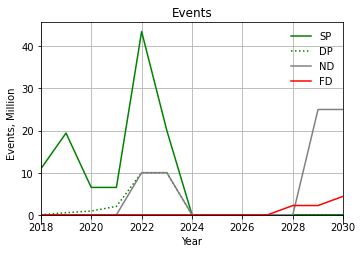

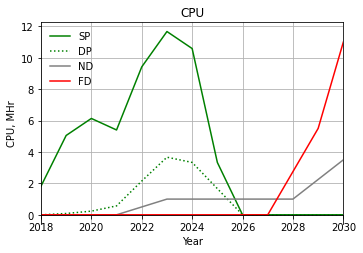

In [13]:
DrawDet("Events",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
#DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)
DrawDet("CPU",Years,Data,Inputs.keys(),Units,DetColors,DetLines)

Combine the protoDUNEs into one and replace them in Data

In [14]:
# combine ProtoDUNEs into one and get rid of SP and DP
 
 
for dtype in Data.keys():
  det = "ProtoDUNE"
  #print (dtype)
  Data[dtype][det] = Data[dtype]["SP"] + Data[dtype]["DP"]
  Data[dtype].pop("SP")
  Data[dtype].pop("DP")

  o.write(dump(det,dtype,Data[dtype][det],Units))

Make a Total-CPU datatype, and a Total "detector" which sums over detectors

In [15]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
  Data["Total-CPU"][det] =  Data["CPU"][det] + Data["Sim-CPU"][det]
  
  
Data.pop("CPU")
# sum up data across detectors.

DataTypes = list(Data.keys())
print (DataTypes)

for dt in DataTypes:
  Data[dt]["Total"] = np.zeros(size)
  for k in Data[dt].keys():
    if k == "Total":
      continue
    Data[dt]["Total"] += Data[dt][k]

['Events', 'Test', 'Sim Events', 'Raw', 'Sim-CPU', 'Reco', 'Sim', 'Total-CPU']


Make an Analysis "detector" that scales with sum of CPU use for all detectors them and add into Total-CPU

In [16]:
# assume analysis CPU = some multiplier of total sim + reco

Data["Total-CPU"]["Analysis"]= np.zeros(size)
for det in config["Analysis"]["Add"]:
    # scale allows you to change the scale of analysis relative to reconstruction and simulations
  Data["Total-CPU"]["Analysis"]+= Data["Total-CPU"][det]*config["Analysis"]["Scale"]
  
o.write(dump("Analysis","Total-CPU",Data["Total-CPU"]["Analysis"],Units))
  
# and put it in the total

Data["Total-CPU"]["Total"] += Data["Total-CPU"]["Analysis"]

Make a Cores type that is just CPU scaled to a 2020 CPU with some efficiency

In [17]:
# and make a special data type for cores

Data["Cores"] = {}
Data["SPEC06"] = {}
MHrsPerYear = 1000000./365/24
for k in Data["Total-CPU"].keys():
  efficiency = config["Cores"]["Efficiency"]
  scaleTo2020 = config["Cores"]["2020Units"]
  Data["Cores"][k] = Data["Total-CPU"][k]*MHrsPerYear/efficiency/scaleTo2020
  Data["SPEC06"][k] = Data["Total-CPU"][k]*MHrsPerYear/efficiency/scaleTo2020*config["kHEPSPEC06PerCPU"]

In [18]:

# write out the totals

for k in Data.keys():
  #print ("total:",k,Units[k], Data[k]["Total"])
  o.write(dump("Total",k,Data[k]["Total"],Units))


Use the data lifetimes and # of copies to sum up cumulative amounts for disk and tape 

In [19]:

# now do some cumulative work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Data["Total"] = {}
Data["Collab"] = {}
Data["Total"]["Cumulative Tape"] = 0
Data["Total"]["Cumulative Disk"] = 0
Data["Collab"]["Cumulative Tape"] = 0
Data["Collab"]["Cumulative Disk"] = 0
print (StorageTypes)


for k in StorageTypes:
  Data[k]["Tape"] = Data[k]["Total"]*TapeCopies[k]
  o.write(dump("Tape Copies",k,Data[k]["Tape"],Units))
  Data[k]["Disk"] = Data[k]["Total"]*DiskCopies[k]
  o.write(dump("Disk Copies",k,Data[k]["Disk"],Units))
  Data[k]["Cumulative Tape"] = cumulate(Data[k]["Tape"],TapeLifetimes[k])
  o.write(dump("Cumulative Tape",k,Data[k]["Cumulative Tape"],Units))
  Data[k]["Cumulative Disk"] = cumulate(Data[k]["Disk"],DiskLifetimes[k])
  o.write(dump("Cumulative Disk",k,Data[k]["Cumulative Disk"],Units ))
  Data["Total"]["Cumulative Tape"] += Data[k]["Cumulative Tape"]
  Data["Total"]["Cumulative Disk"] += Data[k]["Cumulative Disk"]
  Data["Collab"]["Cumulative Disk"] += Data[k]["Cumulative Disk"]*Splits["Disk"][k]
  Data["Collab"]["Cumulative Tape"] += Data[k]["Cumulative Tape"]*Splits["Tape"][k]
o.write(dump("Cumulative Tape","All",Data["Total"]["Cumulative Tape"],Units ))
o.write(dump("Cumulative Disk","All",Data["Total"]["Cumulative Disk"],Units ))

['Raw', 'Test', 'Reco', 'Sim']


163

Draw various summaries

Years,	   CPU(Mhrs),	 Wall-kSPEC06 	 Wall-CPU(cores),	 Tape(PB),	 Collab, 	 Disk(PB)	 Collab

2020,	       30,	       74,	     4915,	     14.2,	      7.1,	     15.1,	     11.1

2021,	       40,	       99,	     6594,	     21.3,	     10.6,	     20.1,	     14.8

2022,	       64,	      157,	    10443,	     39.6,	     19.8,	     31.5,	     22.3

2023,	       73,	      178,	    11835,	     52.7,	     26.4,	     37.0,	     27.2

2024,	       70,	      171,	    11373,	     61.7,	     30.9,	     36.9,	     27.5

2025,	       29,	       72,	     4795,	     65.7,	     32.9,	     26.3,	     19.5

2026,	       29,	       71,	     4729,	     70.9,	     35.4,	     18.2,	     13.4

2027,	       29,	       71,	     4729,	     80.3,	     40.1,	     22.2,	     14.7

2028,	       46,	      114,	     7583,	     95.8,	     47.9,	     29.9,	     20.0

2029,	       54,	      133,	     8888,	    113.6,	     56.8,	     38.1,	     25.7

2030,	       68,	      166,	    11089,	    139.5,	     69.7,	     44.3,	    

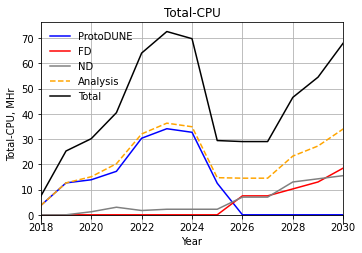

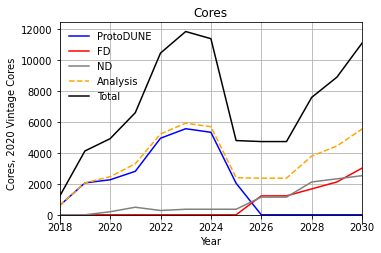

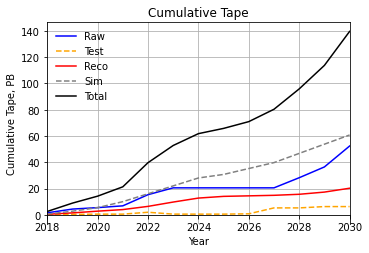

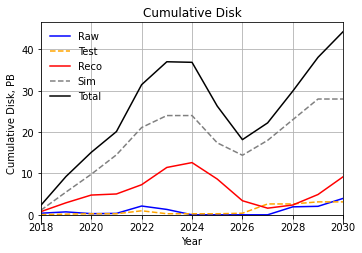

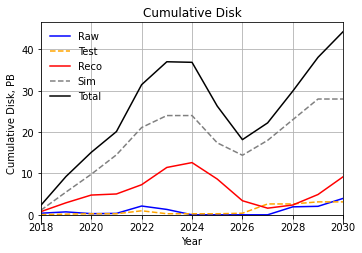

In [20]:
Types = ["ProtoDUNE","FD","ND","Analysis","Total"]

# print (dump("Year","Years",Years,Units))
# print (dump("Total","Cumulative Tape",Data["Total"]["Cumulative Tape"],Units))
# print (dump("Total","Cumulative Disk",Data["Total"]["Cumulative Disk"],Units))


             
s =  "Years,\t   CPU(Mhrs),\t Wall-kSPEC06 \t Wall-CPU(cores),\t Tape(PB),\t Collab, \t Disk(PB)\t Collab\n"
table.write(s)
print(s)
#s = "Assume present core is %6.3f kSPEC06 \nCPU # is real CPU, Cores and SPEC06 are Walltime with CPU/Walltime = %5.2f\n"%(config["kHEPSPEC06PerCPU"], config["Cores"]["Efficiency"])
#print (s)
#table.write(s)


cores = Data["Cores"]["Total"]
cpu = Data["Total-CPU"]["Total"]
disk = Data["Total"]["Cumulative Disk"]
tape = Data["Total"]["Cumulative Tape"]
diskC = Data["Collab"]["Cumulative Disk"]
tapeC = Data["Collab"]["Cumulative Tape"]
hep = Data["SPEC06"]["Total"]
#print (cpu,cores,disk,tape)

for i in range(MinYears,len(Years)):
    
    s = "%d,\t %8.0f,\t %8.0f,\t %8.0f,\t %8.1f,\t %8.1f,\t %8.1f,\t %8.1f\n"%(Years[i],round(cpu[i]),round(hep[i]),round(cores[i]),tape[i],tapeC[i],disk[i],diskC[i])
    print (s)
    table.write(s)
    
s = "Assume present core is %6.3f kSPEC06 \nCPU # is real CPU, Cores and SPEC06 are Walltime with CPU/Walltime = %5.2f\n"%(config["kHEPSPEC06PerCPU"], config["Cores"]["Efficiency"])
print (s)
table.write(s)
    
s = "https://github.com/DUNE/Computing-CDR/blob/master/Jupyter/Numbers/"    
print(s)
table.write(s)

#table.close()
DrawDet("Total-CPU",Years,Data,Types,Units,DetColors,DetLines)
DrawDet("Cores",Years,Data,Types,Units,DetColors,DetLines)
DrawType("Cumulative Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
DrawType("Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)
# draw twice to fool print
DrawType("Cumulative Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines)


In [21]:
table.close()